In [1]:
import pyLabFEM as FE
from pyLabMaterial import Material
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

Yield loci of anisotropic reference material and isotropic material


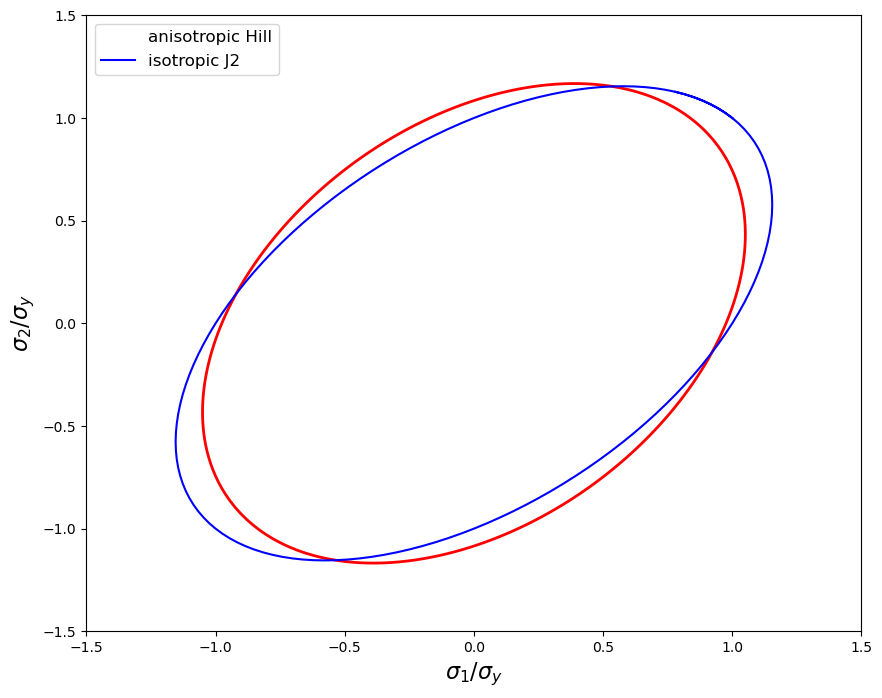

In [2]:
'define two elastic-plastic materials with identical yield strength and elastic properties'
E=200.e3
nu=0.3
sy = 150.
'anistropic Hill-material as reference'
mat_h = Material(name='anisotropic Hill')
mat_h.elasticity(E=E, nu=nu)
mat_h.plasticity(sy=sy, hill=[0.7,1.,1.4], drucker=0., khard=0.)
'isotropic material for ML flow rule'
mat_ml = Material(name='ML flow rule')
mat_ml.elasticity(E=E, nu=nu)
mat_ml.plasticity(sy=sy, hill=[1.,1.,1.], drucker=0., khard=0.)
print('Yield loci of anisotropic reference material and isotropic material')
ax = mat_h.plot_yield_locus(xstart=-1.5, xend=1.5, iso=True)


In [3]:
'Create training data in deviatoric stress space for components seq and theta'
def create_data(N, mat, extend=False, rand=False):
    # create stresses along unit circle normal to hydrostatic axis
    if not rand:
        theta = np.linspace(-np.pi, np.pi, N)
    else:
        theta = 2.*(np.random.rand(N)-0.5)*np.pi
    sig = FE.sp_cart(np.array([np.ones(N)*np.sqrt(3/2), theta]).T)
    offs = 0.01
    x = offs*sig
    N = 23
    for i in range(N):
        hh = offs + (1.4-offs)*(i+1)/N
        x = np.append(x, hh*sig, axis=0)
    if extend:
        # add training points in plastic regime to avoid fallback of SVC decision fct. to zero
        x = np.append(x, 2.*sig, axis=0)
        x = np.append(x, 3.*sig, axis=0)
        x = np.append(x, 4.*sig, axis=0) 
        x = np.append(x, 5.*sig, axis=0)
    'result data for ML yield function (only sign is considered)'
    y = np.sign(mat.calc_yf(x*mat.sy, ana=True))
    return x,y 


In [4]:
'Training and testing data for ML yield function, based on reference Material mat_h'
ndata = 36
ntest = np.maximum(20, int(ndata/10))
x_train, y_train = create_data(ndata, mat_h, extend=True) 
x_test, y_test = create_data(ntest, mat_h, rand=True)
x_train *= mat_h.sy
x_test *= mat_h.sy

In [30]:
print(x_train.shape, x_test.shape)

(1008, 3) (480, 3)


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import Binarizer
from sklearn.metrics import accuracy_score

In [6]:
bin = Binarizer()
y_train = bin.transform(y_train.reshape(-1, 1)).astype(float)
y_test = bin.transform(y_test.reshape(-1, 1)).astype(float)

In [7]:
#!pip install optuna

In [8]:
import optuna

In [9]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(SimpleNN, self).__init__()
        layers = []
        in_units = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(in_units, h_dim))
            layers.append(nn.ReLU())
            in_units = h_dim
        layers.append(nn.Linear(in_units, output_dim))
        layers.append(nn.Sigmoid())
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

def objective(trial):
    # Suggest hyperparameters
    input_dim = 3
    output_dim = 1
    hidden_dims = [trial.suggest_int(f'hidden_dim_{i}', 16, 512) for i in range(trial.suggest_int('n_layers', 1, 7))]
    # hidden_layers = trial.suggest_int('hidden_layers', 1, 5)
    # hidden_units = trial.suggest_int('hidden_units', 8, 64)
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    batch_size = trial.suggest_int('batch_size', 4, 100)

    # Create model, optimizer and loss function
    model = SimpleNN(input_dim, hidden_dims, output_dim)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    # Convert data to PyTorch tensors and DataLoader
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Reshape to [batch_size, 1]
    x_val_tensor = torch.tensor(x_test, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)  # Reshape to [batch_size, 1]

    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Training loop
    for epoch in range(100):  # Set a fixed number of epochs or make it tunable
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, labels = batch
            outputs = model(inputs).view(-1, 1)  # Ensure output is [batch_size, 1]
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(x_val_tensor).view(-1, 1)  # Ensure output is [batch_size, 1]
        val_loss = criterion(val_outputs, y_val_tensor).item()

    # Convert outputs to binary predictions
    binary = Binarizer(threshold=0.5)
    val_pred = binary.transform(val_outputs.numpy())

    # Calculate accuracy
    accuracy = accuracy_score(y_val_tensor.numpy(), val_pred)
    return accuracy




In [10]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  # Increase n_trials for more comprehensive tuning

print(f"Best Trial: {study.best_trial.params}")


[I 2024-08-25 16:01:57,055] A new study created in memory with name: no-name-5e711a13-7f4f-442e-894e-e8f91d51fc72
[I 2024-08-25 16:01:59,616] Trial 0 finished with value: 0.9958333333333333 and parameters: {'n_layers': 7, 'hidden_dim_0': 197, 'hidden_dim_1': 222, 'hidden_dim_2': 131, 'hidden_dim_3': 423, 'hidden_dim_4': 105, 'hidden_dim_5': 18, 'hidden_dim_6': 409, 'lr': 0.0008201791996857502, 'batch_size': 98}. Best is trial 0 with value: 0.9958333333333333.
[I 2024-08-25 16:02:00,444] Trial 1 finished with value: 0.8958333333333334 and parameters: {'n_layers': 3, 'hidden_dim_0': 245, 'hidden_dim_1': 60, 'hidden_dim_2': 87, 'lr': 0.01572750915125478, 'batch_size': 64}. Best is trial 0 with value: 0.9958333333333333.
[I 2024-08-25 16:02:01,259] Trial 2 finished with value: 0.93125 and parameters: {'n_layers': 2, 'hidden_dim_0': 348, 'hidden_dim_1': 103, 'lr': 0.0021019495659926443, 'batch_size': 79}. Best is trial 0 with value: 0.9958333333333333.
[I 2024-08-25 16:02:04,391] Trial 3 fi

KeyboardInterrupt: 

In [16]:
input_dim = 3
output_dim = 1
hidden_dims = [36, 76, 355, 469, 100, 302]
learning_rate = 0.003627873890923467
batch_size = 75

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleNN(input_dim, hidden_dims, output_dim).to(device)
# model = model.double()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Reshape to [batch_size, 1]
x_val_tensor = torch.tensor(x_test, dtype=torch.float32)
y_val_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)  # Reshape to [batch_size, 1]

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(x_val_tensor, y_val_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

patience = 200
best_val_loss = float('inf')
best_model_wts = None
epochs_no_improve = 0
num_epochs = 20000
accuracy_old = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        targets = targets.view(-1, 1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_dataloader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_targets in test_dataloader:
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
            val_targets = val_targets.view(-1, 1)
            val_outputs = model(val_inputs)
            v_loss = criterion(val_outputs, val_targets)
            val_loss += v_loss.item()
        
            

    avg_val_loss = val_loss / len(test_dataloader)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')

    with torch.no_grad():
        pred = model(x_val_tensor)
        binary = Binarizer(threshold=0.5)
        val_outs = binary.transform(pred.numpy())
        accuracy = accuracy_score(y_val_tensor.numpy(), val_outs)
    

    if accuracy > accuracy_old:
        accuracy_old = accuracy
        best_model_wts = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    # if epochs_no_improve >= patience:
    #     # break

model.load_state_dict(best_model_wts)

Epoch [1/20000], Training Loss: 0.6636134322200503, Validation Loss: 0.5917924003941673
Epoch [2/20000], Training Loss: 0.4976429747683661, Validation Loss: 0.46895896962710787
Epoch [3/20000], Training Loss: 0.39284846612385343, Validation Loss: 0.41790767120463507
Epoch [4/20000], Training Loss: 0.5000927884663854, Validation Loss: 0.43847753533295225
Epoch [5/20000], Training Loss: 0.3792297052485602, Validation Loss: 0.29913094746215
Epoch [6/20000], Training Loss: 0.273915205683027, Validation Loss: 0.3977535500058106
Epoch [7/20000], Training Loss: 0.31440004387072157, Validation Loss: 0.310938259852784
Epoch [8/20000], Training Loss: 0.2406832299062184, Validation Loss: 0.2374940389501197
Epoch [9/20000], Training Loss: 0.21198655026299612, Validation Loss: 0.2761820130316274
Epoch [10/20000], Training Loss: 0.21801408912454331, Validation Loss: 0.1718866109315838
Epoch [11/20000], Training Loss: 0.14803324426923478, Validation Loss: 0.1410423144698143
Epoch [12/20000], Training

<All keys matched successfully>

In [17]:
print(accuracy_old)

1.0


In [18]:
model.eval()
with torch.no_grad():
    pred = model(x_val_tensor)

In [19]:
binary = Binarizer(threshold=0.5)
val_predict = binary.transform(pred.numpy())

In [20]:
accuracy = accuracy_score(y_val_tensor.numpy(), val_predict)
print(f'DNN Accuracy: {accuracy}')

DNN Accuracy: 1.0


In [21]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

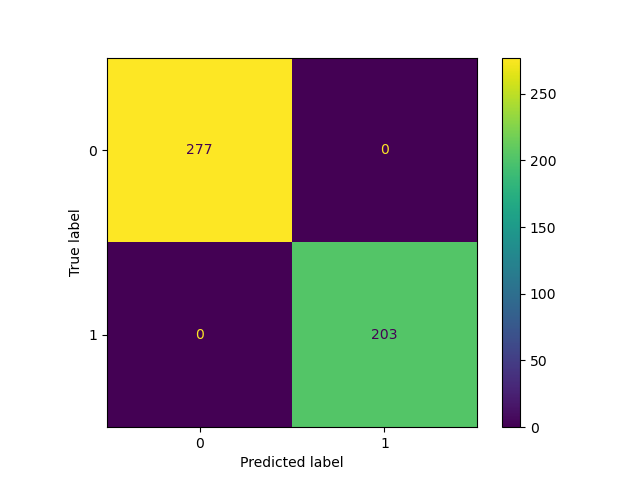

In [145]:
%matplotlib ipympl
disp = ConfusionMatrixDisplay(confusion_matrix(y_val_tensor.numpy(), val_predict))
disp.plot()
plt.show()

In [23]:
torch.save(model.state_dict(), 'DNN_new_Aug25.pt')

## Plots

In [81]:
ndata1 = 360
ntest1 = np.maximum(20, int(ndata1/10))
x_train1, y_train1 = create_data(ndata1, mat_h, extend=True) 
x_test1, y_test1 = create_data(ntest1, mat_h, rand=True)
x_train1 *= mat_h.sy
x_test1 *= mat_h.sy

In [82]:
x_train1.shape

(10080, 3)

In [83]:
p_stress = x_train1

In [84]:
p_stress = np.append(x_train1, x_test1, axis=0)

In [85]:
p_stress.shape

(10944, 3)

In [86]:
# Hill function
def hill_func(pstress):
    hill = np.sqrt(0.5*(0.7*(pstress[:, 0]-pstress[:, 1])**2+1*(pstress[:, 1]-pstress[:, 2])**2
                        +1.4*(pstress[:, 2]-pstress[:, 0])**2))
    return hill

In [87]:
result_hill = hill_func(p_stress)

In [88]:
result_hill[:100]

array([1.88248506, 1.88880467, 1.89507733, 1.90129584, 1.90745316,
       1.91354236, 1.91955668, 1.92548948, 1.93133428, 1.93708473,
       1.94273468, 1.94827809, 1.95370912, 1.95902207, 1.96421141,
       1.9692718 , 1.97419804, 1.97898513, 1.98362822, 1.98812266,
       1.99246397, 1.99664784, 2.00067015, 2.00452696, 2.00821452,
       2.01172923, 2.01506773, 2.01822679, 2.0212034 , 2.02399473,
       2.02659812, 2.02901113, 2.03123146, 2.03325705, 2.03508599,
       2.03671657, 2.03814729, 2.03937679, 2.04040395, 2.04122781,
       2.04184761, 2.04226278, 2.04247293, 2.04247786, 2.04227758,
       2.04187227, 2.0412623 , 2.04044823, 2.03943083, 2.03821103,
       2.03678997, 2.03516896, 2.03334952, 2.03133335, 2.02912234,
       2.02671855, 2.02412426, 2.02134191, 2.01837414, 2.01522379,
       2.01189385, 2.00838753, 2.00470821, 2.00085946, 1.99684502,
       1.99266883, 1.98833499, 1.98384781, 1.97921176, 1.97443149,
       1.96951183, 1.96445778, 1.95927451, 1.95396738, 1.94854

In [89]:
print(np.min(result_hill))

1.674279134157869


In [134]:
plot_ps_hill=np.zeros((1,3))
value_store_hill = np.zeros(1)
#print(value_store_dp)
#print(plot_ps_dp.shape,)
#np.concatenate((plot_ps_dp, [pstrs[20,:]]), axis=0)
#print(plot_ps_dp, [pstrs[20,:]])
last_count_hill=0
for i in range(len(result_hill)):
    if abs(result_hill[i]-150)<3:
        plot_ps_hill=np.append(plot_ps_hill, [p_stress[i,:]], axis=0)
        value_store_hill=np.append(value_store_hill, [result_hill[i]], axis=0)
        #print(plot_ps, pstrs[i,:])
        last_count_hill +=1
print(plot_ps_hill.shape)
print(last_count_hill)
print(value_store_hill.shape)

(208, 3)
207
(208,)


In [121]:
# pstr = x_train
pstr = np.append(x_train, x_test, axis=0)

In [122]:
pstr.shape

(1488, 3)

In [123]:
pstress_tensor = torch.tensor(pstr, dtype=torch.float32)

In [138]:
model.eval()
with torch.no_grad():
    new_pred = model(pstress_tensor)

In [139]:
binary = Binarizer(threshold=0.5)
pred_np = binary.transform(new_pred)

In [140]:
pred_np = pred_np.flatten()

In [141]:
pred_np.shape

(1488,)

In [127]:
print(np.max(pred_np), np.min(pred_np))

1.0 0.0


In [142]:
plot_ps_ml=np.zeros((1,3))
value_store_ml = np.zeros(1)
#print(value_store_dp)
#print(plot_ps_dp.shape,)
#np.concatenate((plot_ps_dp, [pstrs[20,:]]), axis=0)
#print(plot_ps_dp, [pstrs[20,:]])
last_count_ml=0
for i in range(len(pred_np)):
    if abs(pred_np[i])==0:
        plot_ps_ml=np.append(plot_ps_ml, [pstr[i,:]], axis=0)
        value_store_ml=np.append(value_store_ml, [pred_np[i]], axis=0)
        #print(plot_ps, pstrs[i,:])
        last_count_ml +=1
print(plot_ps_ml.shape)
print(last_count_ml)
print(value_store_ml.shape)

(774, 3)
773
(774,)


Text(0.5, 0.92, 'Hill Yield Locus and ML Predicted Elastic Stress States')

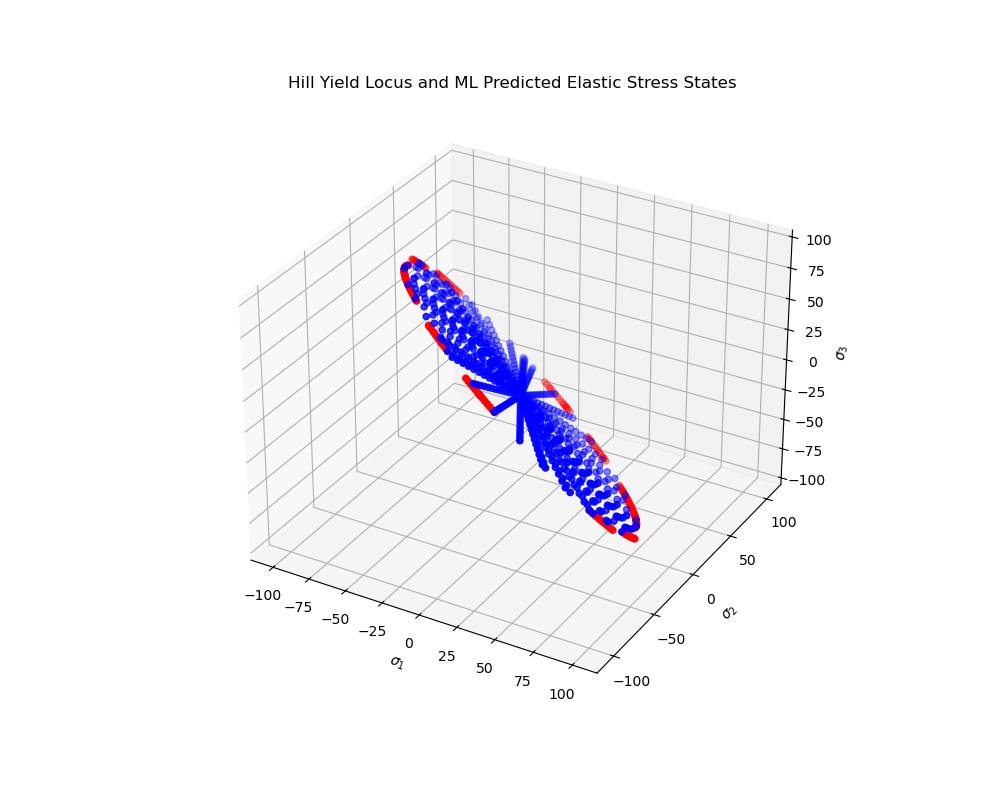

In [144]:
%matplotlib ipympl
plt.figure(figsize=(10, 8))
ax = plt.axes(projection = '3d')
fig = ax.scatter3D(plot_ps_hill[1:,0], plot_ps_hill[1:,1], plot_ps_hill[1:,2], color ='r')
fig = ax.scatter3D(plot_ps_ml[1:,0], plot_ps_ml[1:,1], plot_ps_ml[1:,2], color = 'b')
ax.set_xlabel('$\\sigma_1$')
ax.set_ylabel('$\\sigma_2$')
ax.set_zlabel('$\\sigma_3$')
ax.set_title('Hill Yield Locus and ML Predicted Elastic Stress States')